In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

music = pd.DataFrame()
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]
music['jazz'] = [ 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
                  0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
                  1, 1, 1, 1, 0, 0, 1, 1, 0, 0]

## Distance and Normalizing

In vanilla KNN, distance measurement assumes all units are equal, ie 1 loudness unit is equivalent to 1 second. This also makes it nearly impossible to include binary or categorical variables. Continuous variables work best, but are still problematic when their relative scales are very different (ie sq ft vs. floor)

__Normalization:__ a way of making these measures comparable, there are 2 main techniques

__1)__ Set data bounds to 0 and 1, rescale every variable within these bounds, works best when data shows a linear relationship with known limits to set to 0 and 1 for rescaling

__2)__ Calculate how far each observation is from the mean expressed in number of standard deviations (z-scores), works best for continuous data and puts everything in terms of how far from the mean it is

## Weighting

In vanilla KNN, each vote counts the same regardless of distance from test point. Works fine with densely populated data but is problematic when k nearest observations are not all similarly close to the test. Weight by the inverse of the distance so closer observations have a higher weight than further ones.

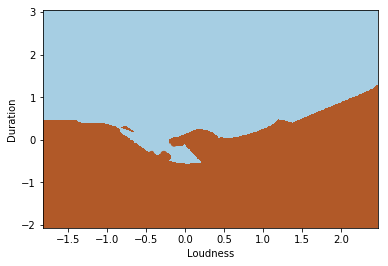

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

neighbors = KNeighborsClassifier(n_neighbors=5,weights='distance')

#input date frame will be z-scores instead of raw data
X = pd.DataFrame({'loudness': stats.zscore(music.loudness),
                  'duration': stats.zscore(music.duration)})

#fit model
Y = music.jazz
neighbors.fit(X,Y)

#arrays (not dfs) for mesh
X = np.array(X)
Y = np.array(Y)

#mesh size
h = .01

#plot decision boundary, assign color to each point in mesh
x_min = X[:,0].min() - .5
x_max = X[:,0].max() + .5
y_min = X[:,1].min() - .5
y_max = X[:,1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

#put result in plot
Z = Z.reshape(xx.shape)
plt.figure(1,figsize=(6,4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

#add training points to the plot
plt.scatter(X[:,0], X[:,1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

__Result:__ more nuanced but relatively continuous and consistent decision boundary

## Choosing k

What is chosen for k is largely up to the data scientist

- Larger k: more smoothed out decision space due to more observations getting a vote

- Smaller k: pick up more subtle deviations, but deviations could just be randomness and result in overfitting

Best technique is to try multiple models and use validation techniques to compare performance. K-fold cross validation is useful for this

## Drill

Let's say we work at a credit card company and we're trying to figure out if people are going to pay their bills on time. We have everyone's purchases, split into four main categories: groceries, dining out, utilities, and entertainment.

__1)__ What are some ways you might use KNN to create this model?

Assuming we also have data available regarding late payments (eg 0 if on time, 1 if late), we could plot categories against one another and to see their relationship between spending an paying. For example, plotting dining out and entertainment together could reveal that the more spent on pleasure indicates a likelihood to either pay on time (more disposable income) or to pay late (more reckless with money). This could also uncover similarities between categories that we could PCA into single features

__2)__ What aspects of KNN would be useful?

Multiple class handling of KNN would be useful, it may make sense to expand our payment class from on-time and late to a more nuanced group, such as on time, under 5 days late (eg. weekend, holiday pushes bank remittance back slightly), within grace period (as CC's often give), and what are truly late payments (>grace period) and even likelihood customers will end up defaulting.

Using weighted distances would be necessary as spending varies wildly across all customers, however this is unlikely to translate to predicting payments.